![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


La base de datos a analizar tiene las siguientes columnas:

- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- holiday : weather day is holiday or not (extracted from [Web Link])
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :

 1: Clear, Few clouds, Partly cloudy, Partly cloudy

 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- total: count of total rental bikes including both casual and registered



### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

* **SEASON**: lo que se observa en los datos es que en promedio el total de bicicletas rentadas baja en temporadas de baja temperatura que esta relacionado con las estaciones de invierno(1) y otoño(4)

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Adicional a lo proporcionado en la celda 1.1, se parte de que la data por estación tiene cantidad de registros similares alrededor de 2700. Para todas las estaciones hay presencia de datos atípicos, esto se sabe porque podemos notar grandes diferencias entre el percentil 75 y el valor máximo (se encuentra en el rango de 800 a 977)

In [5]:
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


* **HOUR**: las horas del día con mayor promedio de cantidad de bicicletas rentadas coincide en las horas pico tipo 8 y 17 donde es normal que muchas personas utilicen este medio de transporte para dirigirse a sus actividades ya sea trabajo, estudio entre otros. Cabe resaltar que desde las 19 hasta las 4 empieza a reducir en promedio el flujo de bicicletas

In [6]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

La variable hour presenta outliers comparando el percentil 75 con el valor máximo, con los valores mínimos se confirma lo mencionado anteriormente respecto a la cantidad de bicicletas rentadas aumentando desde horas pico

In [7]:
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

El número de bicicletas rentadas promedio es mayor en horas 8 y 17. Disminuye desde las 18 hasta las 5.

<Axes: xlabel='hour'>

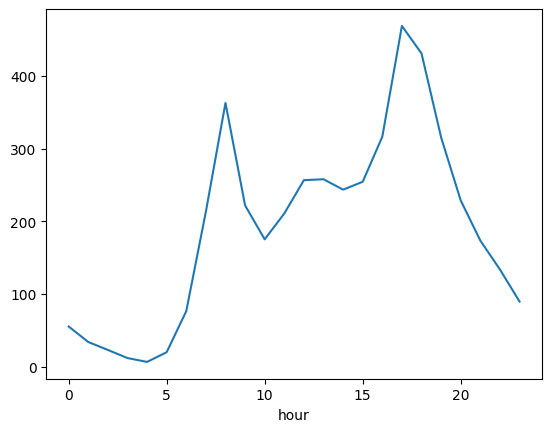

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

El número de bicicletas rentadas promedio en época de invierno es mayor en horas 7,8 y 17. Disminuye desde las 18 hasta las 5. Que cambia respecto al comportamiento total ? El número de bicicletas rentadas promedio máximo es cercano a 300

<Axes: xlabel='hour'>

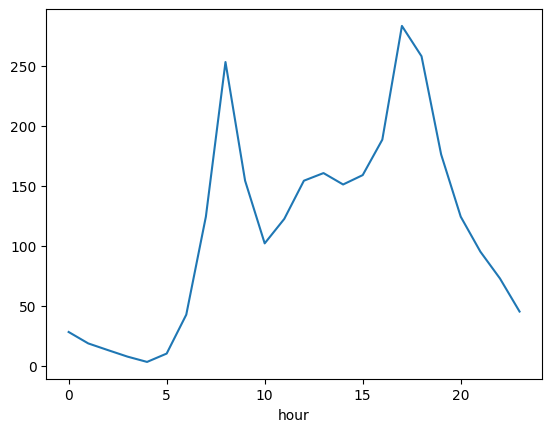

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season']==1].groupby('hour').total.mean().plot()

El número de bicicletas rentadas promedio en época de verano es mayor en horas 7,8 y 17. Disminuye desde las 18 hasta las 5. Que cambia respecto al comportamiento total ? El número de bicicletas rentadas promedio máximo es cercano a 600

<Axes: xlabel='hour'>

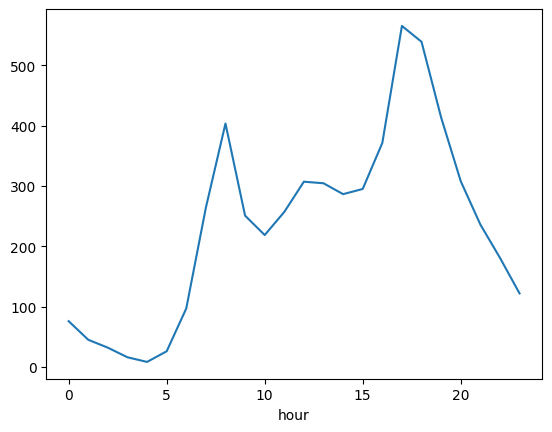

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season']==3].groupby('hour').total.mean().plot()

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [31]:
# Celda 3
#traigo las columnas que necesito
data_reg=bikes[['season','hour','total']]
#paso season a string
data_reg['season']=data_reg['season'].astype(str)
#separo x de y
y=data_reg.total
x=data_reg[['season','hour']]
x['season'] = pd.factorize(x.season)[0]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#ajusto modelo
model=LinearRegression().fit(X_train, y_train)
#imprimo resultados
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")
y_pred = model.predict(X_test)
mse_reg=mean_squared_error(y_test, y_pred)
print(f"mse: {mse_reg}")


intercept: 29.087049016519074
coefficients: [26.93974052 10.5544872 ]
mse: 26898.274894466886


* **Interpretación**: 

El intercepto (29.08) representa el valor esperado de las bicicletas rentadas cuando tanto la estación del año como la hora del día son cero.

El coeficiente para la estación (26.93) significa que, manteniendo constante la hora, se espera que el número de bicicletas rentadas aumente en 26.93 unidades a medida que la estación cambia de 1 a 2, de 2 a 3, y así sucesivamente.

El coeficiente para la hora(10.55) significa que, manteniendo constante la estación, se espera que el número de bicicletas rentadas aumente en 10.55 unidades a medida que la hora avanza en una hora.

* **Limitaciones**:

Este tipo de interpretación no tiene mucho sentido en especial para la variable de season la cual al ser categórica no se interpreta como se esperaría para hacer los debidos análisis.



### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [12]:
def decision_tree_regression_manual(X, y, max_depth=6):
    # Inicializar el árbol con un nodo raíz
    tree = {'split_feature': None, 'split_value': None, 'left': None, 'right': None, 'prediction': np.mean(y)}
    
    # Función para construir el árbol
    def build_tree(X, y, node, depth):
        # Si se alcanza la profundidad máxima, detener la división
        if depth >= max_depth:
            return
        
        # Calcular la MSE de la línea base
        mse_baseline = np.mean((y - np.mean(y)) ** 2)

        # Inicializar variables para el mejor punto de corte y el menor MSE
        best_feature = None
        best_value = None
        best_mse = float('inf')
        
        # Iterar sobre cada variable predictora
        for i in range(X.shape[1]):
            # Calcular todos los puntos de corte posibles para la variable i
            unique_values = np.unique(X.iloc[:, i])
            
            # Iterar sobre cada punto de corte posible
            for value in unique_values:
                # Dividir la muestra en dos grupos: valores menores o iguales al punto de corte y valores mayores al punto de corte
                down = X.iloc[:, i] <= value
                up = X.iloc[:, i] > value
                down_y = y[down]
                up_y = y[up]
                
                # Calcular la MSE para cada grupo
                down_mse = np.mean((down_y - np.mean(down_y)) ** 2)
                up_mse = np.mean((up_y - np.mean(up_y)) ** 2)
                
                # Calcular la MSE total
                total_mse = down_mse + up_mse
                
                # Si el MSE total es menor que el menor MSE encontrado hasta ahora, actualizar las variables
                if total_mse < best_mse:
                    best_feature = i
                    best_value = value
                    best_mse = total_mse
        
        # Si el mejor MSE es menor que el MSE de la línea base, agregar un nodo al árbol y continuar la división
        if best_mse < mse_baseline:
            # Crear dos nuevos nodos para las ramas izquierda y derecha del árbol
            node['split_feature'] = best_feature
            node['split_value'] = best_value
            left_node = {'split_feature': None, 'split_value': None, 'left': None, 'right': None, 'prediction': np.mean(down_y)}
            right_node = {'split_feature': None, 'split_value': None, 'left': None, 'right': None, 'prediction': np.mean(up_y)}
            node['left'] = left_node
            node['right'] = right_node
            
            # Dividir la muestra en dos grupos y continuar la división recursivamente en cada rama del árbol
            left_indices = X.iloc[:, best_feature] <= best_value
            right_indices = X.iloc[:, best_feature] > best_value
            build_tree(X[left_indices], y[left_indices], left_node, depth + 1)
            build_tree(X[right_indices], y[right_indices], right_node, depth + 1)
            
        # Si el mejor MSE no es menor que el MSE de la línea base, no agregar un nodo al árbol y detener la división
        else:
            return
        
    # Llamar a la función recursiva para construir el árbol
    build_tree(X, y, tree, 0)
    
    return tree

# Función para predecir el valor de la variable objetivo 
def predict(tree, X):
    predictions = []
    for i in range(len(X)):
        node = tree
        while node['left'] is not None and node['right'] is not None:
            if X.iloc[i, node['split_feature']] <= node['split_value']:
                node = node['left']
            else:
                node = node['right']
        predictions.append(node['prediction'])
    return np.array(predictions)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#Llamo la funcion que crea el modelo manual
model_manual = decision_tree_regression_manual(X_train,y_train)
#Prediccion para los datos de prueba
y_pred = predict(model_manual, X_test)
# Calcular mse de la muestra de prueba
mse = np.mean((y_test - y_pred)**2)
print("MSE del modelo manual en la muestra de prueba:", mse)

MSE del modelo manual en la muestra de prueba: 28739.576095496715


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la librería sklearn, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

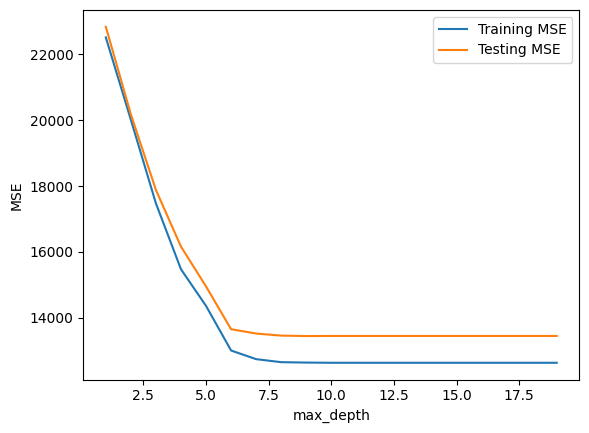

In [14]:
#selecciono el rango a iterar en max_depth
max_depth_values  = range(1, 20)

#particion: desde el modelo manual se hizo la particion
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#lista vacia donde se guardaran los mse
mse_values_test = []
mse_values_train = []

for max_depth in max_depth_values:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    # ajusto modelo con training data
    dt.fit(X_train, y_train)

    # predicciones con testing data
    y_pred_test = dt.predict(X_test)
    y_pred_train = dt.predict(X_train)

    # mse
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_values_test.append(mse_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_values_train.append(mse_train)

# grafica mse y max_depth
plt.plot(max_depth_values, mse_values_train, label='Training MSE')
plt.plot(max_depth_values, mse_values_test, label='Testing MSE')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

El árbol de desición para el caso de regresión tiene un MSE para la data de test de 13451 con un max_depth optimo de 9

In [15]:
#ordeno de menor a mayor mse test
sorted(zip(mse_values_test, max_depth_values))[::1][0]

(13451.363196184311, 9)

El árbol de desición para el caso de regresión tiene un MSE para la data de train de 12640 con un max_depth optimo de 11

In [16]:
#ordeno de menor a mayor mse train
sorted(zip(mse_values_train, max_depth_values))[::1][0]

(12640.597428072695, 11)

In [17]:
#con el menor mse test defino el max_depth
clf = DecisionTreeRegressor(max_depth=9, random_state=42)
clf.fit(x, y)

DecisionTreeRegressor(max_depth=9, random_state=42)

* **Conclusión**: 

Un árbol de decisión y una regresión lineal son dos técnicas diferentes de modelado que se utilizan en el aprendizaje automático para resolver problemas de predicción y clasificación.

Un árbol de decisión es una técnica de aprendizaje automático no paramétrica que se utiliza para clasificar datos en función de una serie de decisiones. Los árboles de decisión son útiles cuando las relaciones entre las variables no son lineales o cuando los datos tienen valores atípicos.

Por otro lado, la regresión lineal es un modelo paramétrico que se utiliza para predecir el valor de una variable continua en función de una o más variables independientes. Este modelo asume que existe una relación lineal entre las variables.

En términos de interpretación, un árbol de decisión puede ser más fácil de entender que una regresión lineal. Un árbol de decisión muestra una secuencia de decisiones y condiciones que conducen a una clasificación o predicción, lo que permite una comprensión sencilla de cómo se realiza la predicción.

Por otro lado, una regresión lineal puede ser más difícil de interpretar, especialmente si hay varias variables independientes involucradas y si la relación entre estas variables es compleja.

En el análisis realizado en el punto 3 notamos que la interpretación no nos ayuda mucho y al realizar el árbol el desempeño del modelo mejora bastante como se muestra a continuación.

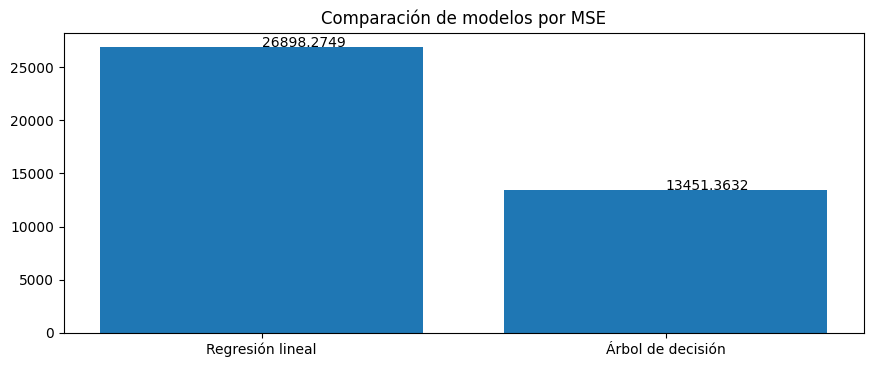

In [33]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por MSE")
#faltan los de filtrado
ejeX = ['Regresión lineal','Árbol de decisión']
ejeY = [mse_reg,sorted(zip(mse_values_test, max_depth_values))[::1][0][0]]
ejeY = [round(v,4) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, VotingClassifier

In [19]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [20]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [21]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

* Árbol de decisión

In [22]:
# Celda 6
# Definir el modelo del Decision Tree Classifier
model_clf = DecisionTreeClassifier()

# Definir la grilla de hiperparámetros para iterar
malla = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Ajustar los hiperparámetros utilizando la grilla de búsqueda
grid_search = GridSearchCV(model_clf, malla)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo
best_tree_clf = grid_search.best_estimator_

# Calcular el Accuracy y F1 Score para el mejor modelo en el conjunto de prueba
y_pred = best_tree_clf.predict(X_test)
accuracy_tree = best_tree_clf.score(X_test, y_test)
f1_tree = f1_score(y_test, y_pred, average='macro')

# Imprimir los resultados
print("Mejores hiperparámetros: {}".format(best_params))


Mejores hiperparámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


* Regresión logística

In [23]:
# Crear el modelo de Regresión Logística
logreg = LogisticRegression()
# Entrenar el modelo con los datos de entrenamiento
logreg.fit(X_train, y_train)
# Realizar predicciones en el conjunto de prueba
y_pred = logreg.predict(X_test)

# Calcular el Accuracy y F1 Score para el modelo
accuracy_log = accuracy_score(y_test, y_pred)
f1_log = f1_score(y_test, y_pred, average='macro')


* Comparación de modelos:

El modelo con mejor desempeño en la data de test es el árbol de decisión con un AUC de 0.6413 y f1 score de 0.6386

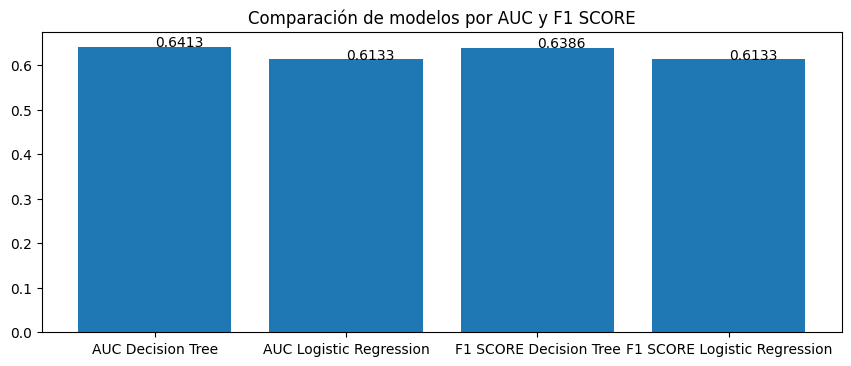

In [24]:
fig = plt.figure(figsize=[8,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por AUC y F1 SCORE")
#faltan los de filtrado
ejeX = ['AUC Decision Tree','AUC Logistic Regression','F1 SCORE Decision Tree','F1 SCORE Logistic Regression']
ejeY = [accuracy_tree,accuracy_log,f1_tree,f1_log]
ejeY = [round(v,4) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

**NOTA:** Se tuvo en cuenta el clasificador de votación duro (hard voting classifier de sklearn ensemble) es un tipo específico de clasificador de votación en el que las predicciones finales se realizan mediante la mayoría de votos de los modelos componentes

In [25]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier

# Creamos las 300 muestras para cada modelo
tree_samples = []
for i in range(300):
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train)
    tree_samples.append((X_train_sample, y_train_sample))

leaf_samples = []
for i in range(300):
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train)
    leaf_samples.append((X_train_sample, y_train_sample))

logistic_samples = []
for i in range(300):
    X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train)
    logistic_samples.append((X_train_sample, y_train_sample))

# Creamos los modelos base
tree_model_1 = DecisionTreeClassifier(max_depth=5)
tree_model_2 = DecisionTreeClassifier(min_samples_leaf=10)
logistic_model = LogisticRegression()

# Creamos las muestras bagged para cada modelo
tree_model_1_bagged = BaggingClassifier(tree_model_1, n_estimators=100, bootstrap=True,random_state=42, n_jobs=-1, oob_score=True)
tree_model_1_bagged.fit(X_train_sample, y_train_sample)

tree_model_2_bagged = BaggingClassifier(tree_model_2, n_estimators=100, bootstrap=True,random_state=42, n_jobs=-1, oob_score=True)
tree_model_2_bagged.fit(X_train_sample, y_train_sample)

logistic_model_bagged = BaggingClassifier(logistic_model, n_estimators=100, bootstrap=True,random_state=42, n_jobs=-1, oob_score=True)
logistic_model_bagged.fit(X_train_sample, y_train_sample)

# Evaluamos cada modelo
for i, model in enumerate([tree_model_1_bagged, tree_model_2_bagged, logistic_model_bagged]):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Modelo {i+1} - Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

# Creamos el ensamble y lo evaluamos
ensemble = VotingClassifier(estimators=[('tree1', tree_model_1_bagged), ('tree2', tree_model_2_bagged), ('logistic', logistic_model_bagged)], voting='hard')
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
acc_ensamble = accuracy_score(y_test, y_pred)
f1_ensamble = f1_score(y_test, y_pred)
print(f"Ensamble - Accuracy: {acc_ensamble:.4f}, F1-Score: {f1_ensamble:.4f}")


Modelo 1 - Accuracy: 0.6513, F1-Score: 0.6516
Modelo 2 - Accuracy: 0.6507, F1-Score: 0.6584
Modelo 3 - Accuracy: 0.6153, F1-Score: 0.6130
Ensamble - Accuracy: 0.6600, F1-Score: 0.6614


**Conclusión:** con el método de votación por mayoritaria si mejora el desempeño de los modelos realizados por lo cual la decisión es realizar el ensamble con un auc de 0.66 y f1 score de 0.66 que son las mayores métricas vs los modelos individuales

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [26]:
modelos=[tree_model_1_bagged, tree_model_2_bagged, logistic_model_bagged]
y_pred_all_= np.zeros((X_test.shape[0], len(modelos)))
errors = np.zeros(len(modelos))

# Se hace un loop sobre cada modelo y se calcula el error y la predicción para cada uno
for i, modelo in enumerate([tree_model_1_bagged, tree_model_2_bagged, logistic_model_bagged]):
  oob_sample = ~modelo.estimators_samples_[i]
  y_pred_ = modelo.estimators_[i].predict(X_train.values[oob_sample])
  errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
  y_pred_all_[:, i] = modelo.estimators_[i].predict(X_test)

# Se calcula el factor de ponderación alpha para cada modelo
alpha = (1 - errors) / (1 - errors).sum()

# Se calcula la predicción final utilizando la suma ponderada de las predicciones de cada modelo
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

acc8 = accuracy_score(y_pred, y_test)
f1score8 = f1_score(y_pred, y_test)

print(f"Accuracy  V. Ponderada: {acc8:.4f}, F1-Score V. Ponderada: {f1score8:.4f}")


Accuracy  V. Ponderada: 0.6353, F1-Score V. Ponderada: 0.6281


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

La elección entre Votación Mayoritaria y Votación Ponderada depende del problema y de la calidad de los modelos que se utilizan en el ensamble.

La Votación Mayoritaria es una técnica en la que cada modelo en el ensamble tiene el mismo peso. Esta técnica es útil cuando se tienen modelos que tienen un desempeño similar y reducen el riesgo de overfitting.

La Votación Ponderada es una técnica en la que se asigna un peso a cada modelo en el ensamble en función de su rendimiento. Esto significa que los modelos que tienen un mejor rendimiento tendrán un peso mayor en la decisión final. Esta técnica es útil cuando se tienen modelos que tienen una calidad muy diferente y se desea mejorar la precisión general del ensamble.

Teniendo en cuenta lo anterior, si los modelos en el ensamble tienen un desempeño similar, la Votación Mayoritaria es una buena opción, mientras que si los modelos tienen una calidad muy diferente, la Votación Ponderada puede ser una mejor opción. 

De acuerdo los modelos realizados, los 3 presentan métricas similares por lo cual podemos suponer que votación mayoritaria tendría un mejor desempeño.

Efectivamente, en la gráfica observamos como la votación mayoritaria tiene un mejor desempeño con auc de 0.66 y f1 score de 0.66

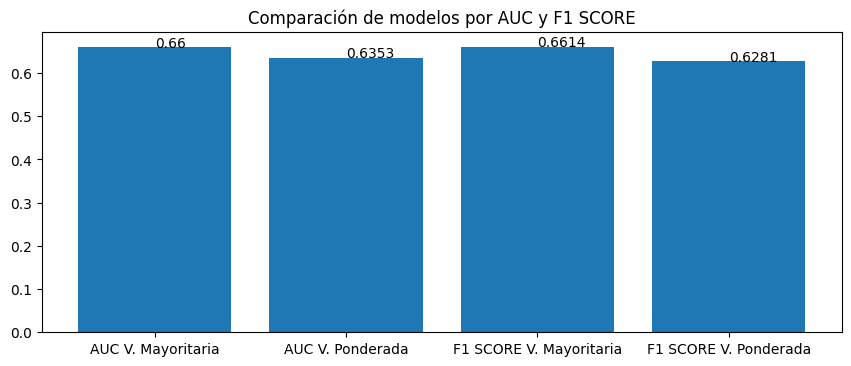

In [27]:
# Celda 9
fig = plt.figure(figsize=[8,3])
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos por AUC y F1 SCORE")
#faltan los de filtrado
ejeX = ['AUC V. Mayoritaria','AUC V. Ponderada','F1 SCORE V. Mayoritaria','F1 SCORE V. Ponderada']
ejeY = [acc_ensamble,acc8,f1_ensamble,f1score8]
ejeY = [round(v,4) for v in ejeY]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()